## Estimate the number of deconvolution iterations

One issue with iterative deconvolution algorithms is the lack of clear stopping criteria. This example demonstrates how use image quality measures (PSNR, SSIM, and FRC) to track the progress of GPU-based RL deconvolution.

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from skimage.io import imread
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from morphocell.preprocessing import deconv_iter_num_finder
from morphocell.metrics import frc_resolution_difference

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
INFO:tensorflow:Disabling eager execution
INFO:tensorflow:Disabling v2 tensorshape
Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Disabling resource variables
INFO:tensorflow:Disabling tensor equality
INFO:tensorflow:Disabling control flow v2


### Load data and the PSF

A single 3D stack of Hoechst-stained astrocyte nuclei acquired with a Yokogawa CQ1 confocal microscope.
Theoretical 3D point spread function (PSF) was modeled using the Richards and Wolf algorithm from the PSFGenerator plugin for Fiji [2].
The image and the PSF can be [downloaded from Google Drive](../data/README.md).

In [2]:
scale_xy = 0.1625
scale_z = 0.3
voxel_sizes = (scale_z, scale_xy, scale_xy)

image = imread("../data/astr_vpa_hoechst.tif")
psf = imread("../data/astr_vpa_hoechst_psf_na095.tif")

Both image and the PSF have the same ZYX size of $30 \times 2160 \times 2560$.

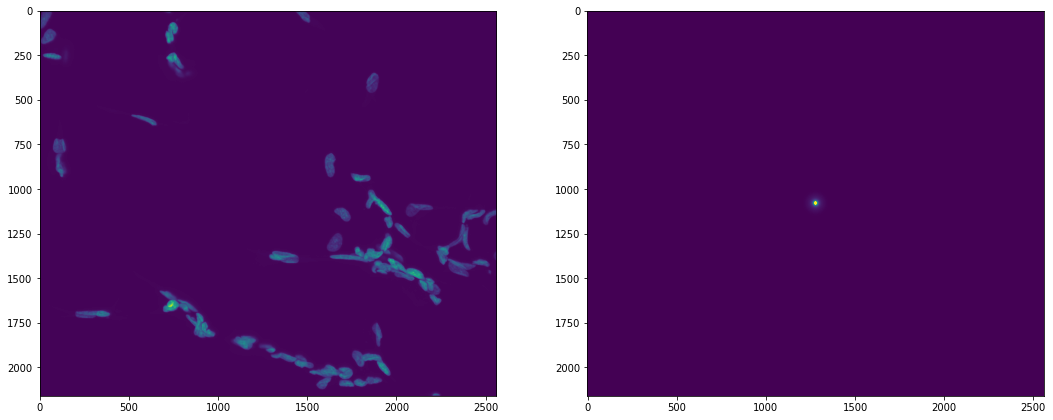

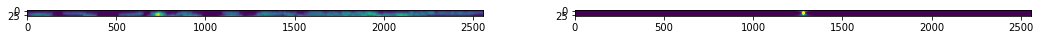

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(image.max(0))
axes[1].imshow(psf.max(0), vmax=0.01)
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(image.max(1))
axes[1].imshow(psf.max(1), vmax=0.01)
plt.show()

### Use PSNR improvement as a metric of decon quality

Here we demonstrate how to use peak signal-to-noise ratio (PSNR) as a criteria for determining the number of RL iterations.
MorphoCell will run RL on a GPU and at each iteration compare restored image with one from the previous iteration.
By default, images are padded in Z in 'reflect' mode on both sides up to 32 slices.

When provided threshold is reached, it returns the number of iterations and an object metric gains and intermediate images from all iterations.
Note that the RL will run for full `max_iter` iterations.
For better performance, metric computation stops after the treshold is reached, which can make the difference when metric computation is a bottleneck (e.g., for FRC).

We use fast GPU-based RL imaplementation from `flowdec` library [3].

In [ ]:
psnr_thresh_iter, psnr_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=peak_signal_noise_ratio,
    metric_threshold=80.0,
    max_iter=30,
    scales=voxel_sizes,
    verbose=True,
)

Deconvolving image.shape=(32, 2160, 2560) with psf.shape=(32, 2160, 2560)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Iteration 1: improvement 57.89200737
Iteration 2: improvement 61.84020239
Iteration 3: improvement 64.17221221
Iteration 4: improvement 65.91824863
Iteration 5: improvement 67.34773139
Iteration 6: improvement 68.57165896
Iteration 7: improvement 69.64821943
Iteration 8: improvement 70.61276798
Iteration 9: improvement 71.48886272
Iteration 10: improvement 72.29300603
Iteration 11: improvement 73.03741329
Iteration 12: improvement 73.73125876
Iteration 13: improvement 74.38154121
Iteration 14: improvement 74.99390423
Iteration 15: improvement 75.57300221
Iteration 16: improvement 76.12230841
Iteration 17: improvement 76.64505839
Iteration 18: improvement 77.14380637
Iteration 19: improvement 77.62052612
Iteration 20: improvement 78.07729670
Iteration 21: improvement 78.51553227

Now we can visualize the progress according to the provided metric.

PSNR doesn't quite plateau before reaching this threshold of 80 dB, which means it can be further increased, if needed.

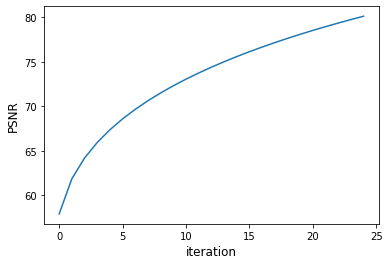

In [5]:
plt.plot([res["metric_gain"] for res in psnr_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("PSNR", fontsize=12)
plt.show()

And visualize original and restored images from the iteration at threshold next to each other.

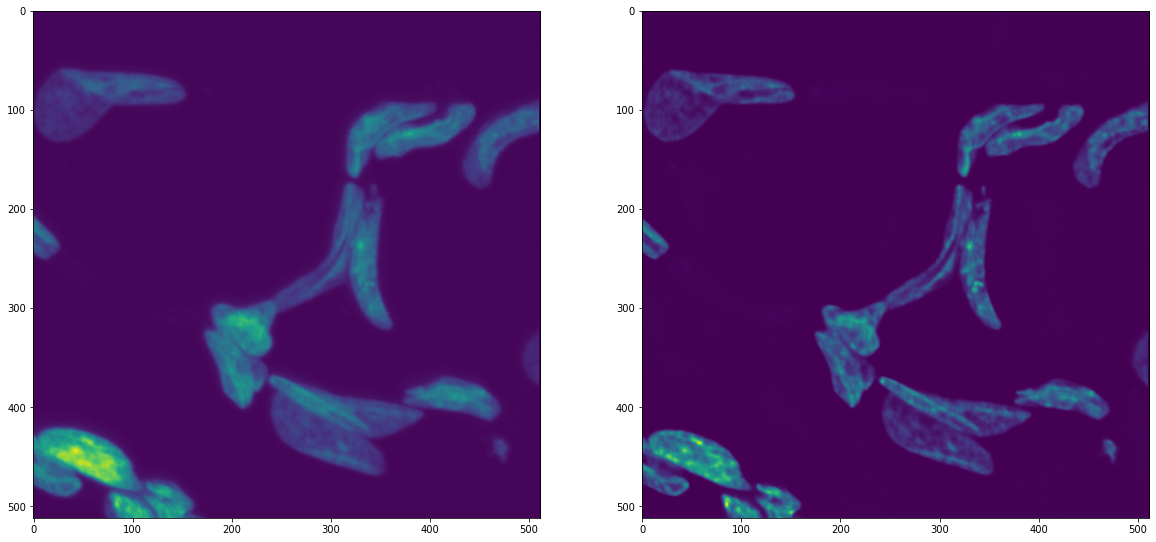

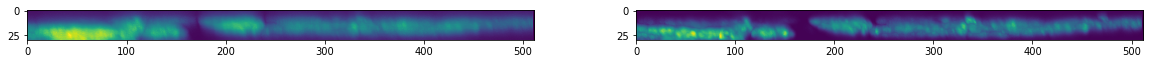

In [ ]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(0))
axes[1].imshow(psnr_resolution[psnr_thresh_iter]["iter_image"][patch].max(0))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(1))
axes[1].imshow(psnr_resolution[psnr_thresh_iter]["iter_image"][patch].max(1))
plt.show()

### Use SSIM improvement as a metric of decon quality

Now, we repeat the process using structured similarity index (SSIM) as a progress metric instead.

In [ ]:
ssim_thresh_iter, ssim_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=structural_similarity,
    metric_threshold=0.99999,
    max_iter=25,
    scales=voxel_sizes,
    verbose=True,
)

Deconvolving image.shape=(32, 2160, 2560) with psf.shape=(32, 2160, 2560)
Iteration 1: improvement 0.99895614
Iteration 2: improvement 0.99957971
Iteration 3: improvement 0.99976375
Iteration 4: improvement 0.99984726
Iteration 5: improvement 0.99989303
Iteration 6: improvement 0.99992105
Iteration 7: improvement 0.99993951
Iteration 8: improvement 0.99995232
Iteration 9: improvement 0.99996157
Iteration 10: improvement 0.99996847
Iteration 11: improvement 0.99997374
Iteration 12: improvement 0.99997785
Iteration 13: improvement 0.99998112
Iteration 14: improvement 0.99998374
Iteration 15: improvement 0.99998589
Iteration 16: improvement 0.99998766
Iteration 17: improvement 0.99998914
Iteration 18: improvement 0.99999038

Threshold 0.99999 reached at iteration 18 with improvement: 0.99999038.
Metric between original and restored images: 0.98338693.


Deconvolution info: {'data_shape': array([  32, 2160, 2560], dtype=int32), 'kern_shape': array([  32, 2160, 2560], dtype=int32), 'pad_sha

When visualized, SSIM shows reachin a plateau even before 10 iterations. This makes sense, because SSIM measures the perceived change in structural information, while PSNR estimates an absolute error.

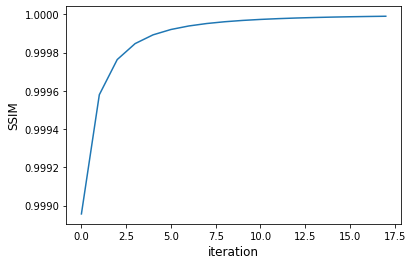

In [8]:
plt.plot([res["metric_gain"] for res in ssim_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.show()

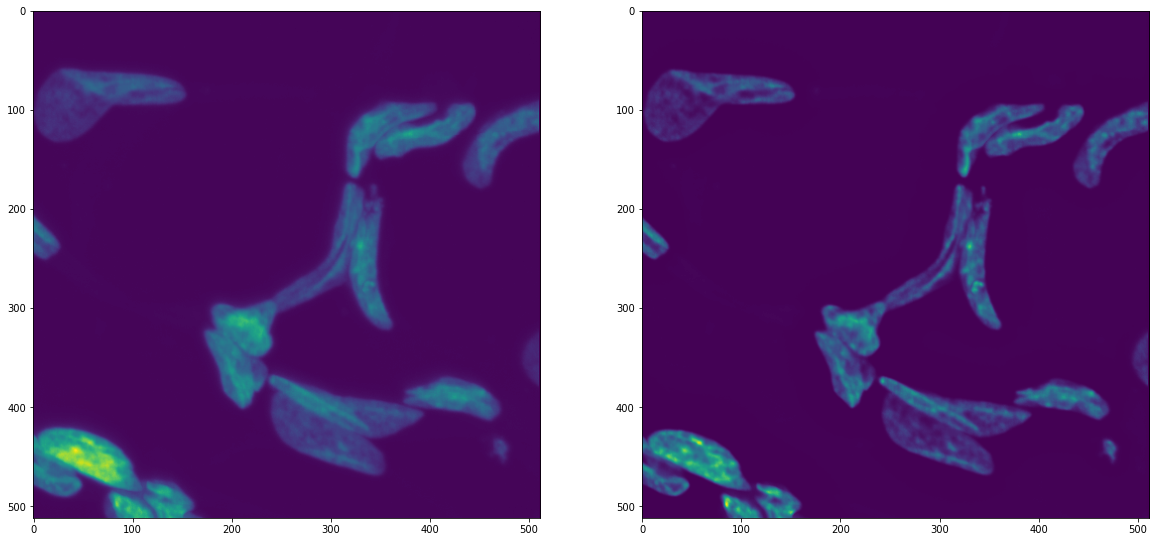

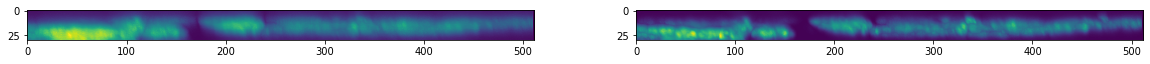

In [ ]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(0))
axes[1].imshow(ssim_resolution[ssim_thresh_iter]["iter_image"][patch].max(0))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(1))
axes[1].imshow(ssim_resolution[ssim_thresh_iter]["iter_image"][patch].max(1))
plt.show()

### Use FRC-based resolution estimation improvement as a metric of decon quality

Finally, we employ Fourier Ring Correlation (FRC)-based image resolution estimation as a metric of RL progress [4]:


> FRC has recently gained popularity as a method to measure the effective image resolution. It is based on a normalized cross-correlation histogram measure calculated in the frequency domain between two images of the same region-of-interest, with independent noise realizations. Advantages of the FRC/FSC are that it is fully automatic, quantitative, and depends both on sample and microscope characteristics. It is also less prone to subjective bias and measurement errors, although the choice of the appropriate resolution threshold criterion still requires some input from the researcher, as no single solution seems to be correct in all applications.

MorphoCell provides FRC-based resolution metric, which requires a few parameters, for example, `axis` along which 2D FRC is calculated in the 3D image, or `frc_bin_delta`, which sets the thickness of the ring for FRC calculation (see other options in `miplib.ui.cli.frc_options` in [5]). It will also rescale images to isotropic voxels according to provided `voxel_sizes` prior to computing FRC.

The specified resolution threshold assumes a nanometer length scale, which is meaningful in optical microscopy. It needs to be adjusted for appropriate physical units, when working with images with significantly higher or lower resolution, see [4].

In [ ]:
frc_thresh_iter, frc_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=frc_resolution_difference,
    metric_kwargs={
        "frc_bin_delta": 3,
        "axis": "xy",
        "scales": (scale_z, scale_xy, scale_xy),
    },
    metric_threshold=-5.0,  # frc_resolution_difference returns improvement in nm it^−1
    max_iter=25,
    scales=voxel_sizes,
    verbose=True,
)

Deconvolving image.shape=(32, 2160, 2560) with psf.shape=(32, 2160, 2560)
Iteration 1: improvement -193.22656390
Iteration 2: improvement -49.42188103
Iteration 3: improvement -35.91607031
Iteration 4: improvement -36.46941251
Iteration 5: improvement -33.19917941
Iteration 6: improvement -27.97333617
Iteration 7: improvement -24.59001527
Iteration 8: improvement -21.14500184
Iteration 9: improvement -19.16807209
Iteration 10: improvement -17.03171693
Iteration 11: improvement -16.02655528
Iteration 12: improvement -13.73235408
Iteration 13: improvement -11.49017340
Iteration 14: improvement -10.53295074
Iteration 15: improvement -9.95581375
Iteration 16: improvement -9.03598417
Iteration 17: improvement -8.38081076
Iteration 18: improvement -6.99242545
Iteration 19: improvement -6.75066556
Iteration 20: improvement -5.88551653
Iteration 21: improvement -5.66984979
Iteration 22: improvement -5.31636905
Iteration 23: improvement -4.87421148

Threshold -5.0 reached at iteration 23 with i

Visualization of FRC-based RL progress shows that the estimated number of iterations is similar to one obtained using PSNR, but most of the resolution gains have been made when the set threshold is reached.

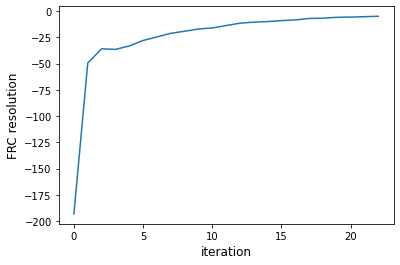

In [11]:
plt.plot([res["metric_gain"] for res in frc_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("FRC resolution", fontsize=12)
plt.show()

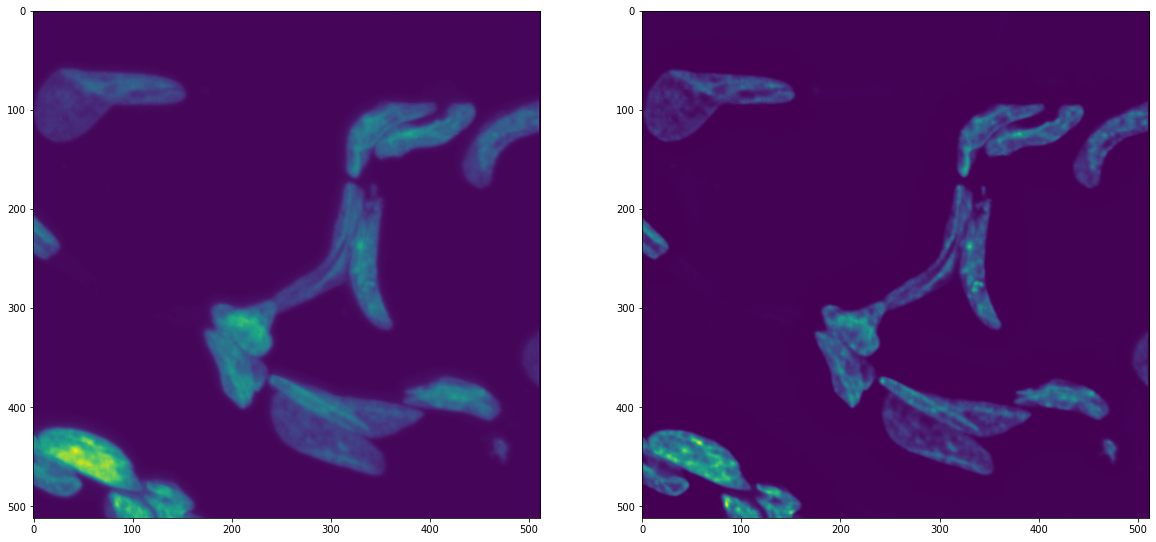

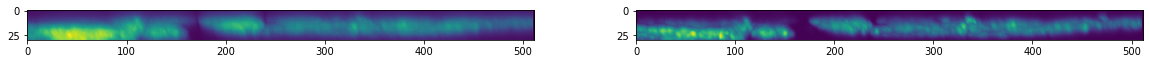

In [ ]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(0))
axes[1].imshow(frc_resolution[frc_thresh_iter]["iter_image"][patch].max(0))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image[patch].max(1))
axes[1].imshow(frc_resolution[frc_thresh_iter]["iter_image"][patch].max(1))
plt.show()

### References

[2] http://bigwww.epfl.ch/algorithms/psfgenerator/

[3] https://github.com/hammerlab/flowdec

[4] Koho, Sami, et al. "Fourier ring correlation simplifies image restoration in fluorescence microscopy." Nature communications 10.1 (2019): 1-9.

[5] https://github.com/sakoho81/miplib